# Load libraries

In [2]:
!pip install catboost
!pip install pytorch-tabnet
!pip install scikit-multilearn
!pip install shap
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account 

In [3]:
# libreries for general scopes
import numpy as np
import pandas as pd
import math
import gc

# sklearn modules for modeling
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, recall_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, make_scorer, hamming_loss, log_loss
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import OrdinalEncoder
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.problem_transform import LabelPowerset

from sklearn.linear_model import LogisticRegression, RidgeClassifier
# from imblearn.over_sampling import SMOTE
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
# from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
# from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor

import shap

# libraries to make plots
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc

# apply some cool styling
plt.style.use("ggplot")
pd.set_option("display.max_columns", 100)
%matplotlib inline


# Custom functions

In [4]:
def iterative_train_test_split(X, y, train_size, order):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    # Iteratively stratify a multi-label data set into folds
    # the stratifier splits the dataset into folds trying to maintain balanced representation with respect to order-th label combinations.
    # order = 1 means independence among class labels
    # order = 2 considers correlations between a pair of class labels
    # order > 2 consider correlations among all the class labels or subsets of class labels
    # http://proceedings.mlr.press/v74/szyma%C5%84ski17a/szyma%C5%84ski17a.pdf

    stratifier = IterativeStratification(
        n_splits=2, 
        order=order, 
        sample_distribution_per_fold=[1.0-train_size, train_size] # desired percentage of samples in each of the folds
      )   

    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

In [5]:
def evaluate_predictions(y_preds, y_preds_labels, y_true):
  scores = dict()
  # multi-label and multi-task case
  if y_true.shape[1]>1:
    scores['roc_auc_macro'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='macro')
    scores['roc_auc_micro'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='micro')
    scores['roc_auc_weighted'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='weighted')
    scores['recall_macro'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='macro')
    scores['recall_micro'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='micro')
    scores['recall_weighted'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='weighted')
    scores['f1_macro'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='macro')
    scores['f1_micro'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='micro')
    scores['f1_weighted'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='weighted')
    scores['accuracy'] = accuracy_score(y_eval, y_preds_labels)
  return scores

# Load data

In [6]:
# Cloning repo to local disc
!git clone https://github.com/andreafedele/student-performance

Cloning into 'student-performance'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), 23.65 KiB | 2.63 MiB/s, done.


In [7]:
df_por = pd.read_csv("student-performance/student-por.csv", sep=';')
df_mat = pd.read_csv("student-performance/student-mat.csv", sep=';')

print('Nr of Maths students:', df_mat.shape)
print('Nr of Portuguese students:', df_por.shape)

Nr of Maths students: (395, 33)
Nr of Portuguese students: (649, 33)


In [8]:
df_feat_description = pd.read_csv("student-performance/feature-description.csv", sep=';')
df_feat_description

,feature,description
0,school,"student's school (binary: ""GP"" - Gabriel Pere..."
1,sex,"student's sex (binary: ""F"" - female or ""M"" - ..."
2,age,student's age (numeric: from 15 to 22)
3,address,"student's home address type (binary: ""U"" - ur..."
4,famsize,"family size (binary: ""LE3"" - less or equal to..."
5,Pstatus,"parent's cohabitation status (binary: ""T"" - l..."
6,Medu,"mother's education (numeric: 0 - none, 1 - p..."
7,Fedu,"father's education (numeric: 0 - none, 1 - p..."
8,Mjob,"mother's job (nominal: ""teacher"", ""health"" ca..."
9,Fjob,"father's job (nominal: ""teacher"", ""health"" ca..."


In [9]:
df_por.G3.describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

# Merge dataframes? Nope
We fit the model on the portuguese dataset, then we test it on the math dataset to check its robustness.


In [ ]:
# comm_student=pd.merge(df_mat, df_por,how='inner',
#                       on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], suffixes=('_por','_mat'))

In [ ]:
# comm_student.shape

In [ ]:
# pd.merge(df_mat,df_por,
#                       on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], suffixes=('_por','_mat'))[['id_por','id_mat']]

In [ ]:
# comm_student.head()

In [ ]:
# df_mat.head()

# Data Preprocessing

## Data Exploration Analysis

In [ ]:
task_type = 'multiclass' # or 'multilabel'

In [ ]:
# Grades range from 0 to 20
# if task_type == 'multilabel':
y_por = df_por[['G1','G2','G3']]
X_por = df_por.drop(columns=['G1','G2','G3'])
# else:
#   y_por = df_por[['G3']]
#   X_por = df_por.drop(columns=['G3'])

In [ ]:
X_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

<Axes: xlabel='G3', ylabel='Count'>

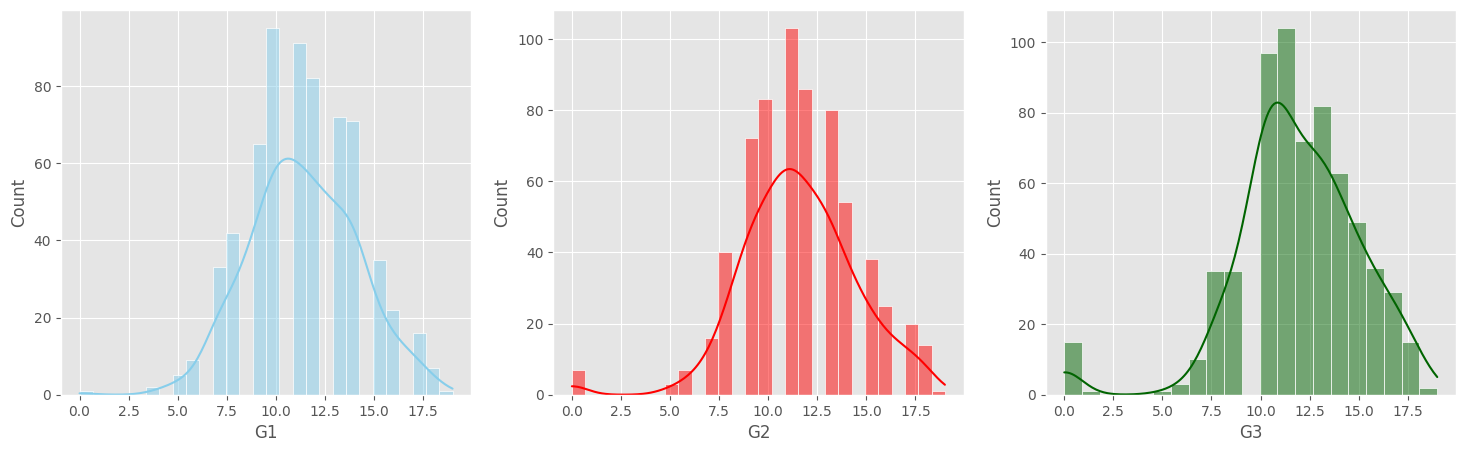

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

sns.histplot(data=df_por, x="G1", color="skyblue", label="Grade 1", kde=True, ax=axs[0])
sns.histplot(data=df_por, x="G2", color="red", label="Grade 2", kde=True, ax=axs[1])
sns.histplot(data=df_por, x="G3", color="darkgreen", label="Grade 3", kde=True, ax=axs[2])

# plt.legend() 
# plt.show()

### Age and gender distribution

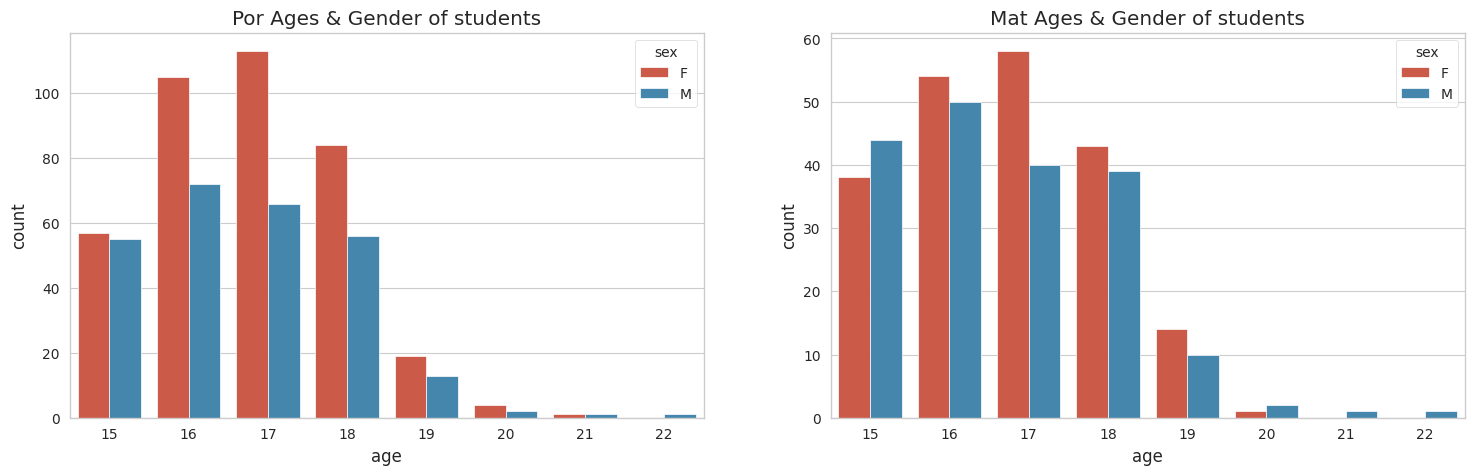

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
p = sns.countplot(data = df_por, x='age', hue='sex', ax=axs[0])
m = sns.countplot(data = df_mat, x='age', hue='sex', ax=axs[1])
p.axes.set_title('Por Ages & Gender of students')
m.axes.set_title('Mat Ages & Gender of students')
plt.show()

13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


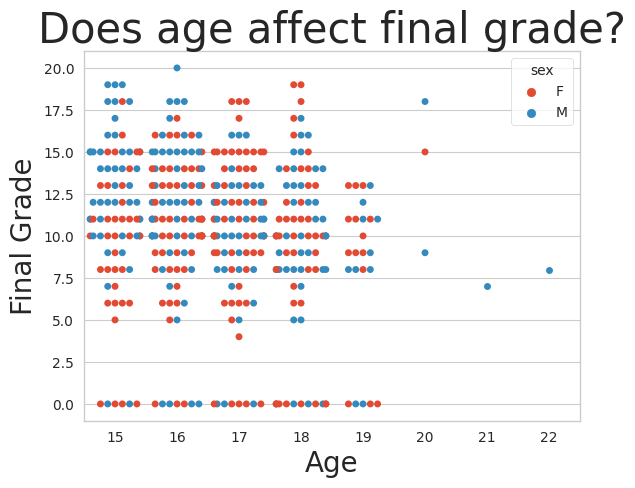

In [ ]:
b = sns.swarmplot(x='age', y='G3',hue='sex', data=df_mat)
b.axes.set_title('Does age affect final grade?', fontsize = 30)
b.set_xlabel('Age', fontsize = 20)
b.set_ylabel('Final Grade', fontsize = 20)
plt.show()

## Encoding categorical variables
CatBoost can handle categorical variables. According to the documentation it is prefereable to not use one-hot encoding during preprocessing as this affects both the training speed and the resulting quality.

In [ ]:
cat_cols = X_por.columns[X_por.dtypes == "object"].values

In [ ]:
len(cat_cols)

17

In [ ]:
numeric_cols = X_por.columns[X_por.dtypes != "object"].values
nominal_cols = [] # 4
binary_cols = [] # 14
for c in X_por.columns[X_por.dtypes == "object"].values:
  if len(X_por[c].unique()) == 2:
    binary_cols.append(c)
  else:
    nominal_cols.append(c)

Nominal binary variables will be converted to numerical binary variables

In [ ]:
# we keep track of the original feature values so that we can use them during the explanation part
X_por_enc = X_por.copy()
enc_bin = OrdinalEncoder( dtype=int)
X_por_enc[binary_cols] = enc_bin.fit_transform(X_por_enc[binary_cols])

Nominal variables with more than 2 categories will be one-hot encoded ('Mjob', 'Fjob', 'reason', 'guardian')

In [ ]:
sh_before = X_por_enc.shape[1]
X_por_enc = pd.get_dummies(X_por_enc, 
                            columns=nominal_cols, 
                            drop_first=False)
sh_after = X_por_enc.shape[1]
print('N features before one-hot-encoding: ', sh_before)
print('N features after one-hot-encoding: ', sh_after)
print('Added columns: ', sh_after-sh_before)
X_por_enc.head()

N features before one-hot-encoding:  30
N features after one-hot-encoding:  43
Added columns:  13


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
1,0,0,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,0,15,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,0,0,15,1,0,1,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,0,0,16,1,0,1,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0


In [ ]:
X_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0


## Explore missing values

There are no missing values

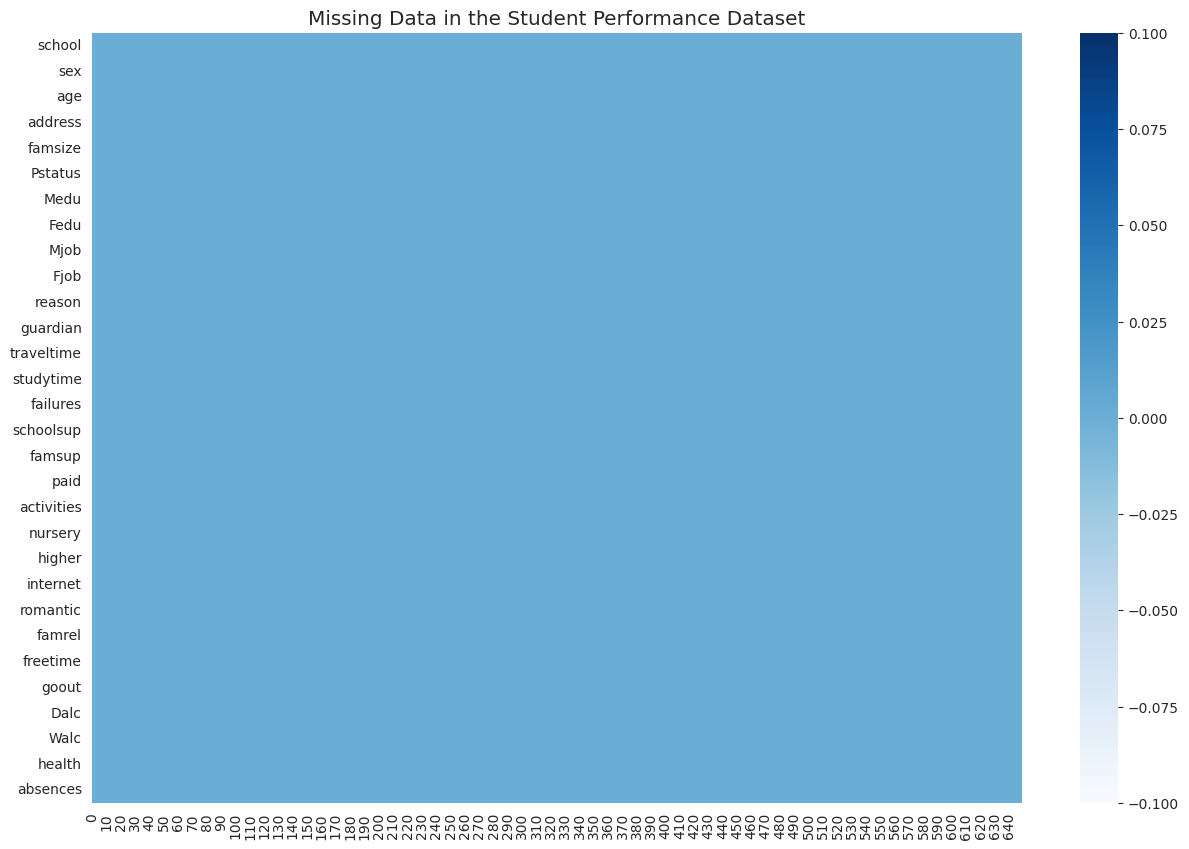

In [ ]:
plt.subplots(figsize=(15,10))  
sns.heatmap(X_por.isnull().transpose(), cmap = 'Blues')
plt.title("Missing Data in the Student Performance Dataset")
plt.show()

## Feature correlation with target

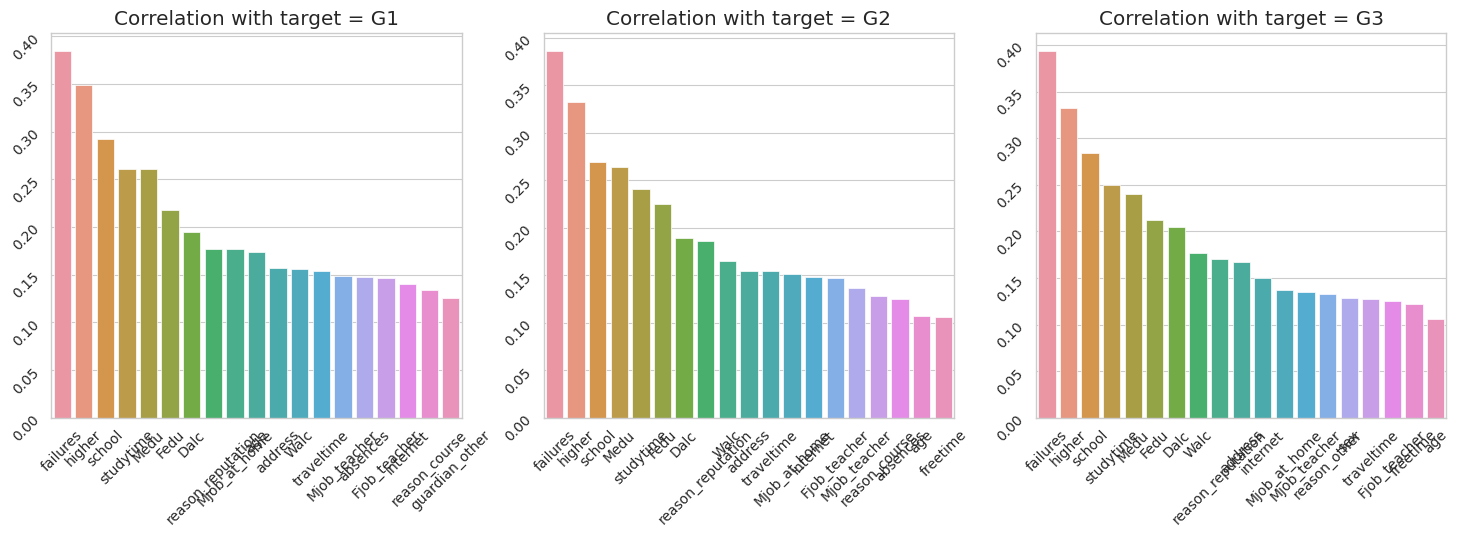

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
X_por_enc_corr = X_por_enc.copy()

# G1
X_por_enc_corr['target'] = y_por['G1']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[0])
axs[0].set_title("Correlation with target = G1")
axs[0].tick_params(labelrotation= 45)

# G2
X_por_enc_corr['target'] = y_por['G2']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[1])
axs[1].set_title("Correlation with target = G2")
axs[1].tick_params(labelrotation= 45)

# G3
X_por_enc_corr['target'] = y_por['G3']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[2])
axs[2].set_title("Correlation with target = G3")
axs[2].tick_params(labelrotation= 45)

del X_por_enc_corr

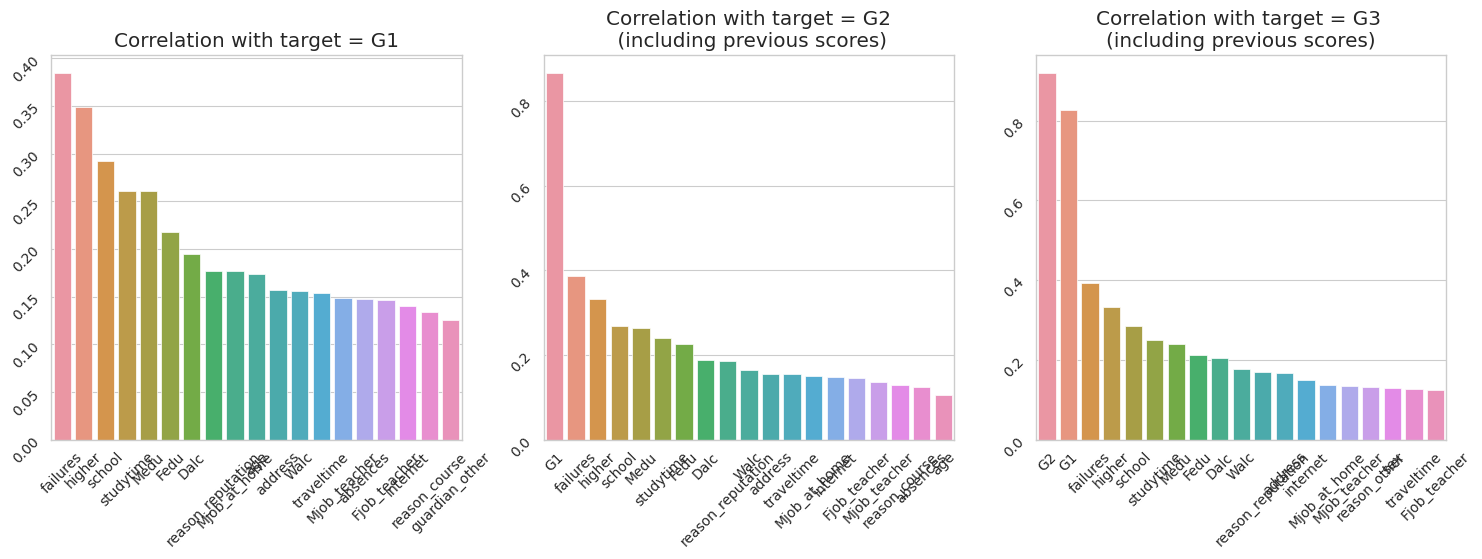

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
X_por_enc_corr = X_por_enc.copy()

# G1
X_por_enc_corr['target'] = y_por['G1']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[0])
axs[0].set_title("Correlation with target = G1")
axs[0].tick_params(labelrotation= 45)

# G2
X_por_enc_corr['target'] = y_por['G2']
X_por_enc_corr_temp = X_por_enc_corr.merge(y_por['G1'], left_index=True, right_index=True)
corr_train = X_por_enc_corr_temp.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[1])
axs[1].set_title("Correlation with target = G2\n (including previous scores)")
axs[1].tick_params(labelrotation= 45)

# G3
X_por_enc_corr['target'] = y_por['G3']
X_por_enc_corr_temp = X_por_enc_corr.merge(y_por[['G1','G2']], left_index=True, right_index=True)
corr_train = X_por_enc_corr_temp.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[2])
axs[2].set_title("Correlation with target = G3 \n(including previous scores)")
axs[2].tick_params(labelrotation= 45)

del X_por_enc_corr

# Regression
The model can be queried at three different time points:
* For the assignment of the first grade, i.e., to predict G1 given the features only (we can expect this to return very biased results with very low accuracy)
* For the assignment of the second grade, i.e., to predict G2 given the features AND G1
* For the assignment of the thirs grade, i.e., to predict G3 given the features AND G1 AND G2

Regression models used:
* Linear Regression
* CatBoost Regressor
* Random Forest Regressor
* Support Vector Regressor
* K-Nearest Neighbors for Regression
* XGBoost Regressor

In [ ]:
model_list = dict(
    linearRegression = LinearRegression(), 
    knn = KNeighborsRegressor(), 
    randomForest = RandomForestRegressor(random_state=123), 
    svr = SVR(), 
    catb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', random_seed=123),#(task_type="GPU"), 
    xgb = XGBRegressor(random_seed=123)#(tree_method='gpu_hist', gpu_id=0)
    )
grid_params = dict(
    linearRegression=dict(),
    knn=dict(n_neighbors=[2,3,4,5], 
                weights=['uniform','distance'],
                p=[1,2,5]
                ),
    randomForest=dict(max_depth=[10, 50, 100],
      max_features=['log2', 'sqrt'],
      min_samples_leaf=[2, 4, 6],
      n_estimators=[100, 300, 500]),
    svr=dict(
        kernel = ['poly', 'rbf', 'poly'],
        C = [50, 10, 1.0, 0.1, 0.01],
        gamma = [1e-7, 1e-4],
        epsilon=[0.1,0.2,0.5,0.3]),
    catb=dict(
        iterations=[100, 150, 200],
        learning_rate=[0.03, 0.1],
        depth=[2, 4, 6, 8],
        l2_leaf_reg=[0.2, 0.5, 1, 3]),
    xgb=dict(
        max_depth=[2,  4, 6],
        learning_rate=[.03, 0.05, .07],
        colsample_bytree=[0.2, 0.6, 0.8],
        n_estimators=[100, 500, 1000])
    )

In [ ]:
def train_test_split_by_grade(X_por_enc, y_por, grade):
  # prepare features:
  if grade == 'G2':
    X_por_enc = X_por_enc.merge(y_por[['G1']], left_index=True, right_index=True)
  elif grade == 'G3':
    X_por_enc = X_por_enc.merge(y_por[['G1','G2']], left_index=True, right_index=True)

  # Oversampling
  # oversample = SMOTE()
  # X_por_enc_smote, y_por_smote = oversample.fit_resample(X_por_enc, y_por[grade])
  
  # Scaling
  # sc_X = StandardScaler()
  # sc_y = StandardScaler()
  # X_por_enc = pd.DataFrame(sc_X.fit_transform(X_por_enc), columns=X_por_enc.columns)
  # y_por = pd.DataFrame(sc_y.fit_transform(y_por), columns=y_por.columns)  

  # Split the training set into train + eval (0.8-0.2 proportion)
  X_por_train, X_por_eval, y_por_train, y_por_eval = train_test_split(X_por_enc, y_por[grade], 
                                                                    #stratify=y_por['G1'], 
                                                                    random_state = 123,
                                                                    test_size=0.2)
  return X_por_train, X_por_eval, y_por_train, y_por_eval

In [ ]:
def get_model_predictions(X_por_train, X_por_eval, y_por_train, y_por_eval, grade, model, grid, finetune):
  """ grade (str): grade to be computed, either 'G1', 'G2' or 'G3'
      grid (dict): grid for grid search in hyperparameter tuning
      returns:
        - fitted model
        - predictions on test set
        - RMSE and R2 on train and test set
  """
  print('Predicting grade ', grade)
  
  if finetune:
    print('Hyperparameter finetuning of method', model)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error',error_score=0, verbose=0)
    grid_result = grid_search.fit(X_por_train, y_por_train.values.ravel())  
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    model = grid_search.best_estimator_
  else:
    model.fit(X_por_train, y_por_train.values.ravel())

  # Train metrics
  predictions_train = model.predict(X_por_train)
  rmse_train = (np.sqrt(mean_squared_error(y_por_train, predictions_train)))
  r2_train = r2_score(y_por_train, predictions_train)
  train_metrics = dict(rmse=rmse_train, r2=r2_train)
  
  # Get predictions
  print('Getting predictions for grade ', grade)
  predictions = model.predict(X_por_eval)
  # Test metrics
  rmse = (np.sqrt(mean_squared_error(y_por_eval, predictions)))
  r2 = r2_score(y_por_eval, predictions)
  test_metrics = dict(rmse=rmse, r2=r2)
  
  print("Train performance")
  print("RMSE: {:.2f}".format(rmse_train))
  print("R2: {:.2f}".format(r2_train))

  print("Test performance")
  print("RMSE: {:.2f}".format(rmse))
  print("R2: {:.2f}".format(r2))
  
  return model, predictions, train_metrics, test_metrics

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1 = train_test_split_by_grade(X_por_enc, y_por, 'G1')
X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g2 = train_test_split_by_grade(X_por_enc, y_por, 'G2')
X_por_train_g3, X_por_eval_g3, y_por_train_g3, y_por_eval_g3 = train_test_split_by_grade(X_por_enc, y_por, 'G3')

### Linear Regression

In [ ]:
g1_model_lr, g1_predictions_lr, g1_train_metrics_lr, g1_test_metrics_lr =  get_model_predictions(X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1, 'G1', model_list['linearRegression'], grid_params['linearRegression'], False)

Predicting grade  G1
Getting predictions for grade  G1
Train performance
RMSE: 2.18
R2: 0.38
Test performance
RMSE: 2.29
R2: 0.22


In [ ]:
g2_model_lr, g2_predictions_lr, g2_train_metrics_lr, g2_test_metrics_lr =  get_model_predictions(X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g2, 'G2', model_list['linearRegression'], grid_params['linearRegression'], False)

Predicting grade  G2
Getting predictions for grade  G2
Train performance
RMSE: 1.39
R2: 0.76
Test performance
RMSE: 1.51
R2: 0.76


In [ ]:
g3_model_lr, g3_predictions_lr, g3_train_metrics_lr, g3_test_metrics_lr = get_model_predictions(X_por_train_g3, X_por_eval_g3, y_por_train_g3, y_por_eval_g3, 'G3', model_list['linearRegression'], grid_params['linearRegression'], False)

Predicting grade  G3
Getting predictions for grade  G3
Train performance
RMSE: 1.20
R2: 0.86
Test performance
RMSE: 1.27
R2: 0.85


## Catboost Regression

In [ ]:
g1_model_cb, g1_predictions_cb, g1_train_metrics_cb, g1_test_metrics_cb = get_model_predictions(X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1, 'G1', model_list['catb'], grid_params['catb'], True)

Predicting grade  G1
Hyperparameter finetuning of method <catboost.core.CatBoostRegressor object at 0x7f6fb03d1240>
Best: -2.260056 using {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Getting predictions for grade  G1
Train performance
RMSE: 1.64
R2: 0.65
Test performance
RMSE: 2.19
R2: 0.28


In [ ]:
g2_model_cb, g2_predictions_cb, g2_train_metrics_cb, g2_test_metrics_cb = get_model_predictions(X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g2, 'G2', model_list['catb'], grid_params['catb'], True)

Predicting grade  G2
Hyperparameter finetuning of method <catboost.core.CatBoostRegressor object at 0x7f6fb03d1240>
Best: -1.463983 using {'depth': 2, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}
Getting predictions for grade  G2
Train performance
RMSE: 1.31
R2: 0.79
Test performance
RMSE: 1.47
R2: 0.77


In [ ]:
g3_model_cb, g3_predictions_cb, g3_train_metrics_cb, g3_test_metrics_cb = get_model_predictions(X_por_train_g2, X_por_eval_g3, y_por_train_g3, y_por_eval_g2, 'G3', model_list['catb'], grid_params['catb'], True)

Predicting grade  G3
Hyperparameter finetuning of method <catboost.core.CatBoostRegressor object at 0x7f6fb03d1240>
Best: -1.722436 using {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
Getting predictions for grade  G3
Train performance
RMSE: 1.34
R2: 0.83
Test performance
RMSE: 1.46
R2: 0.77


## Random Forest Regressor

In [ ]:
g1_model_rf, g1_predictions_rf, g1_train_metrics_rf, g1_test_metrics_rf = get_model_predictions(X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1, 'G1', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G1
Hyperparameter finetuning of method RandomForestRegressor(random_state=123)
Best: -2.311922 using {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300}
Getting predictions for grade  G1
Train performance
RMSE: 1.54
R2: 0.69
Test performance
RMSE: 2.18
R2: 0.29


In [ ]:
g2_model_rf, g2_predictions_rf, g2_train_metrics_rf, g2_test_metrics_rf = get_model_predictions(X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g2, 'G2', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G2
Hyperparameter finetuning of method RandomForestRegressor(random_state=123)
Best: -1.761986 using {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500}
Getting predictions for grade  G2
Train performance
RMSE: 1.05
R2: 0.86
Test performance
RMSE: 1.82
R2: 0.65


In [ ]:
g3_model_rf, g3_predictions_rf, g3_train_metrics_rf, g3_test_metrics_rf = get_model_predictions(X_por_train_g3, X_por_eval_g3, y_por_train_g3, y_por_eval_g3, 'G3', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G3
Hyperparameter finetuning of method RandomForestRegressor(random_state=123)
Best: -1.627736 using {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Getting predictions for grade  G3
Train performance
RMSE: 0.96
R2: 0.91
Test performance
RMSE: 1.64
R2: 0.75


## Support Vector Regressor

In [ ]:
g1_model_svr, g1_predictions_svr, g1_train_metrics_svr, g1_test_metrics_svr = get_model_predictions(X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1, 'G1', model_list['svr'], grid_params['svr'], True)

Predicting grade  G1
Hyperparameter finetuning of method SVR()
Best: -2.431740 using {'C': 50, 'epsilon': 0.2, 'gamma': 0.0001, 'kernel': 'rbf'}
Getting predictions for grade  G1
Train performance
RMSE: 2.35
R2: 0.28
Test performance
RMSE: 2.28
R2: 0.23


In [ ]:
g2_model_svr, g2_predictions_svr, g2_train_metrics_svr, g2_test_metrics_svr = get_model_predictions(X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g2, 'G2', model_list['svr'], grid_params['svr'], True)

Predicting grade  G2
Hyperparameter finetuning of method SVR()
Best: -1.463928 using {'C': 50, 'epsilon': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
Getting predictions for grade  G2
Train performance
RMSE: 1.42
R2: 0.75
Test performance
RMSE: 1.53
R2: 0.75


In [ ]:
g3_model_svr, g3_predictions_svr, g3_train_metrics_svr, g3_test_metrics_svr = get_model_predictions(X_por_train_g3, X_por_eval_g3, y_por_train_g3, y_por_eval_g3, 'G3', model_list['svr'], grid_params['svr'], True)

Predicting grade  G3
Hyperparameter finetuning of method SVR()
Best: -1.284091 using {'C': 50, 'epsilon': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
Getting predictions for grade  G3
Train performance
RMSE: 1.27
R2: 0.84
Test performance
RMSE: 1.20
R2: 0.87


## K-Nearest Neighbors for Regression

In [ ]:
g1_model_knr, g1_predictions_knr, g1_train_metrics_knr, g1_test_metrics_knr = get_model_predictions(X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1, 'G3', model_list['knn'], grid_params['knn'], True)

Predicting grade  G3
Hyperparameter finetuning of method KNeighborsRegressor()
Best: -2.678970 using {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
Getting predictions for grade  G3
Train performance
RMSE: 2.10
R2: 0.42
Test performance
RMSE: 2.51
R2: 0.06


In [ ]:
g2_model_knr, g2_predictions_knr, g2_train_metrics_knr, g2_test_metrics_knr = get_model_predictions(X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g3, 'G2', model_list['knn'], grid_params['knn'], True)

Predicting grade  G2
Hyperparameter finetuning of method KNeighborsRegressor()
Best: -1.651921 using {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Getting predictions for grade  G2
Train performance
RMSE: 0.00
R2: 1.00
Test performance
RMSE: 1.97
R2: 0.64


In [ ]:
g3_model_knr, g3_predictions_knr, g3_train_metrics_knr, g3_test_metrics_knr = get_model_predictions(X_por_train_g3, X_por_eval_g3, y_por_train_g3, y_por_eval_g3, 'G3', model_list['knn'], grid_params['knn'], True)

Predicting grade  G3
Hyperparameter finetuning of method KNeighborsRegressor()
Best: -1.401477 using {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Getting predictions for grade  G3
Train performance
RMSE: 0.00
R2: 1.00
Test performance
RMSE: 1.49
R2: 0.79


## XGB Regressor

In [ ]:
g1_model_xgb, g1_predictions_xgb, g1_train_metrics_xgb, g1_test_metrics_xgb = get_model_predictions(X_por_train_g1, X_por_eval_g1, y_por_train_g1, y_por_eval_g1, 'G1', model_list['catb'], grid_params['catb'], True)

Predicting grade  G1
Hyperparameter finetuning of method <catboost.core.CatBoostRegressor object at 0x7f6fb03d1240>
Best: -2.260056 using {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Getting predictions for grade  G1
Train performance
RMSE: 1.64
R2: 0.65
Test performance
RMSE: 2.19
R2: 0.28


In [ ]:
g2_model_xgb, g2_predictions_xgb, g2_train_metrics_xgb, g2_test_metrics_xgb = get_model_predictions(X_por_train_g2, X_por_eval_g2, y_por_train_g2, y_por_eval_g2, 'G2', model_list['catb'], grid_params['catb'], True)

Predicting grade  G2
Hyperparameter finetuning of method <catboost.core.CatBoostRegressor object at 0x7f6fb03d1240>
Best: -1.463983 using {'depth': 2, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}
Getting predictions for grade  G2
Train performance
RMSE: 1.31
R2: 0.79
Test performance
RMSE: 1.47
R2: 0.77


In [ ]:
g3_model_xgb, g3_predictions_xgb, g3_train_metrics_xgb, g3_test_metrics_xgb = get_model_predictions(X_por_train_g3, X_por_eval_g3, y_por_train_g3, y_por_eval_g3, 'G3', model_list['catb'], grid_params['catb'], True)

Predicting grade  G3
Hyperparameter finetuning of method <catboost.core.CatBoostRegressor object at 0x7f6fb03d1240>
Best: -1.239677 using {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}
Getting predictions for grade  G3
Train performance
RMSE: 0.70
R2: 0.95
Test performance
RMSE: 1.27
R2: 0.85


## **Models evaluation**

Evaluation on the train dataset

In [ ]:
lr_dict_tr = pd.DataFrame.from_dict(dict(G1=g1_train_metrics_lr,G2=g2_train_metrics_lr,G3=g3_train_metrics_lr),
                       orient='index')
cb_dict_tr = pd.DataFrame.from_dict(dict(G1=g1_train_metrics_cb,G2=g2_train_metrics_cb,G3=g3_train_metrics_cb),
                       orient='index')
rf_dict_tr = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_rf,G2=g2_test_metrics_rf,G3=g3_test_metrics_rf), # change this later
                       orient='index')
svr_dict_tr = pd.DataFrame.from_dict(dict(G1=g1_train_metrics_svr,G2=g2_train_metrics_svr,G3=g3_train_metrics_svr),
                       orient='index')
knn_dict_tr = pd.DataFrame.from_dict(dict(G1=g1_train_metrics_knr,G2=g2_train_metrics_knr,G3=g3_train_metrics_knr),
                       orient='index')
xgb_dict_tr = pd.DataFrame.from_dict(dict(G1=g1_train_metrics_xgb,G2=g2_train_metrics_xgb,G3=g3_train_metrics_xgb),
                       orient='index')

In [ ]:
pd.concat([lr_dict_tr,cb_dict_tr,rf_dict_tr,svr_dict_tr,knn_dict_tr,xgb_dict_tr],
          keys=['Linear Regression','CatBoost','Random Forest','SVR','Knn Regression','XGBoost'], 
          axis=1)

Linear Regression            CatBoost           Random Forest            \
                rmse        r2      rmse        r2          rmse        r2   
G1          2.182207  0.379189  1.636067  0.651045      2.183118  0.289698   
G2          1.394421  0.763761  1.307380  0.792333      1.819397  0.646964   
G3          1.204806  0.858862  1.335872  0.826484      1.635382  0.753412   

         SVR           Knn Regression             XGBoost            
        rmse        r2           rmse        r2      rmse        r2  
G1  2.354745  0.277138        2.10067  0.424715  1.636067  0.651045  
G2  1.423107  0.753941        0.00000  1.000000  1.307380  0.792333  
G3  1.274427  0.842079        0.00000  1.000000  0.696802  0.952791

Evaluation on test dataset

In [ ]:
lr_dict = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_lr,G2=g2_test_metrics_lr,G3=g3_test_metrics_lr),
                       orient='index')
cb_dict = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_cb,G2=g2_test_metrics_cb,G3=g3_test_metrics_cb),
                       orient='index')
rf_dict = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_rf,G2=g2_test_metrics_rf,G3=g3_test_metrics_rf),
                       orient='index')
svr_dict = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_svr,G2=g2_test_metrics_svr,G3=g3_test_metrics_svr),
                       orient='index')
knn_dict = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_knr,G2=g2_test_metrics_knr,G3=g3_test_metrics_knr),
                       orient='index')
xgb_dict = pd.DataFrame.from_dict(dict(G1=g1_test_metrics_xgb,G2=g2_test_metrics_xgb,G3=g3_test_metrics_xgb),
                       orient='index')

In [ ]:
pd.concat([lr_dict,cb_dict,rf_dict,svr_dict,knn_dict,xgb_dict],
          keys=['Linear Regression','CatBoost','Random Forest','SVR','Knn Regression','XGBoost'], 
          axis=1)

Linear Regression            CatBoost           Random Forest            \
                rmse        r2      rmse        r2          rmse        r2   
G1          2.291365  0.217512  2.193855  0.282693      2.183118  0.289698   
G2          1.509255  0.757065  1.468138  0.770121      1.819397  0.646964   
G3          1.271490  0.850940  1.456197  0.773846      1.635382  0.753412   

         SVR           Knn Regression             XGBoost            
        rmse        r2           rmse        r2      rmse        r2  
G1  2.278765  0.226095       2.514955  0.057352  2.193855  0.282693  
G2  1.534716  0.748800       1.969460  0.642375  1.468138  0.770121  
G3  1.199728  0.867291       1.492120  0.794723  1.269492  0.851409

Observations:
* On the train dataset:
  - Best RMSE: KNN Regression, SVR (G1, G2, G3)
  - Best R2: 
    - G1: KNN Regression, CatBoost
    - G2 & G3: KNN Regression, Random Forest
* On the **test** dataset:
  - Best RMSE: 
    - XGBoost, SVR (G1, G2 & G3)
  - Best R2: 
    - G1: CatBoost, XGBoost
    - G2 & G3: XGBoost, CatBoost

# Confidence estimate

# Explainability
Will be done on math dataset 

In [ ]:
import lime
import lime.lime_tabular

# feature selection
from sklearn.feature_selection import chi2

shap.initjs()

Math dataset pre-processing

In [10]:
def preprocess_df(df):
  y = df[['G1','G2','G3']]
  X = df.drop(columns=['G1','G2','G3'])

  cat_cols = X.columns[X.dtypes == "object"].values

  numeric_cols = X.columns[X.dtypes != "object"].values
  nominal_cols = [] # 4
  binary_cols = [] # 14
  for c in X.columns[X.dtypes == "object"].values:
    if len(X[c].unique()) == 2:
      binary_cols.append(c)
    else:
      nominal_cols.append(c)

  # we keep track of the original feature values so that we can use them during the explanation part
  X_enc = X.copy()
  enc_bin = OrdinalEncoder( dtype=int)
  X_enc[binary_cols] = enc_bin.fit_transform(X_enc[binary_cols])

  X_enc = pd.get_dummies(X_enc, 
                            columns=nominal_cols, 
                            drop_first=False)
  return X, y, X_enc

def prepare_datasets(X_train, y_train, X_test, y_test, grade):

  # adjust datasets
  if grade == 'G1':
    y_train = y_train[['G1']]
    y_test = y_test[['G1']]
  elif grade == 'G2':
    X_train = X_train.merge(y_train[['G1']], left_index=True, right_index=True)
    X_test = X_test.merge(y_test[['G1']], left_index=True, right_index=True)
    y_train = y_train[['G2']]
    y_test = y_test[['G2']]
  elif grade == 'G3':
    X_train = X_train.merge(y_train[['G1','G2']], left_index=True, right_index=True)
    X_test = X_test.merge(y_test[['G1','G2']], left_index=True, right_index=True)
    y_train = y_train[['G3']]
    y_test = y_test[['G3']]
  
  return X_train, y_train, X_test, y_test

In [11]:
def get_test_prediction_on_math(model, grade, X_enc_por, y_por, X_mat_enc, y_mat):

  # Fit the model
  model.fit(X_enc_por, y_por.values.ravel())

  # Get predictions
  print('Getting predictions for grade', grade)
  predictions = model.predict(X_mat_enc)

  # Test metrics
  rmse = (np.sqrt(mean_squared_error(y_mat[[grade]], predictions)))
  r2 = r2_score(y_mat[[grade]], predictions)
  test_metrics = dict(rmse=rmse, r2=r2)

  print("Test performance")
  print("RMSE: {:.2f}".format(rmse))
  print("R2: {:.2f}".format(r2))

  return model, predictions, test_metrics

In [12]:
best_models = dict(
    g1 = RandomForestRegressor(random_state=123, max_depth=10, max_features='sqrt', min_samples_leaf= 2, n_estimators=300),
    g2 = XGBRegressor(random_seed=123, depth=2,iterations= 200, l2_leaf_reg= 0.5,learning_rate= 0.03),
    g3 = XGBRegressor(random_seed=123, depth=4,iterations= 100, l2_leaf_reg= 0.2,learning_rate= 0.1)
)

In [13]:
X_mat, y_mat, X_enc_mat  = preprocess_df(df_mat)
X_por, y_por, X_enc_por  = preprocess_df(df_por)

In [14]:
X_train_g1, y_train_g1, X_test_g1, y_test_g1 = prepare_datasets(X_enc_por, y_por, X_enc_mat, y_mat, 'G1')
X_train_g2, y_train_g2, X_test_g2, y_test_g2 = prepare_datasets(X_enc_por, y_por, X_enc_mat, y_mat, 'G2')
X_train_g3, y_train_g3, X_test_g3, y_test_g3 = prepare_datasets(X_enc_por, y_por, X_enc_mat, y_mat, 'G3')

## G1

In [31]:
model_g1, predictions_g1, test_metrics_g1 = get_test_prediction_on_math(best_models['g1'], 'G1', X_train_g1, y_train_g1, X_test_g1, y_test_g1)

Getting predictions for grade G1
Test performance
RMSE: 2.96
R2: 0.20


In [32]:
model_g2, predictions_g2, test_metrics_g2 = get_test_prediction_on_math(best_models['g2'], 'G2', X_train_g2, y_train_g2, X_test_g2, y_test_g2)

[15:42:26] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.

Getting predictions for grade G2
Test performance
RMSE: 2.08
R2: 0.69


In [33]:
model_g3, predictions_g3, test_metrics_g3 = get_test_prediction_on_math(best_models['g3'], 'G3', X_train_g3, y_train_g3, X_test_g3, y_test_g3)

[15:42:28] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.

Getting predictions for grade G3
Test performance
RMSE: 2.14
R2: 0.78


In [17]:
idx_exp = 367
print('Regression for grade G1: ', predictions_g1[idx_exp] )
print('Regression for grade G2: ', predictions_g2[idx_exp] )
print('Regression for grade G3: ', predictions_g3[idx_exp] )

Regression for grade G1:  8.847971719386042
Regression for grade G2:  5.5107083
Regression for grade G3:  8.028662


#### Confidence

In [15]:
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        return grad, hess
    return _log_cosh_quantile

In [17]:
# over predict
alpha = 0.95
model = XGBRegressor(objective=log_cosh_quantile(alpha),
                       n_estimators=125,
                       max_depth=4,
                       n_jobs=6,
                       learning_rate=.1,
                     l2_leaf_reg= 0.2,
                     iterations=100,
                     random_seed=123)

model.fit(X_train_g3, y_train_g3)
y_upper_smooth = model.predict(X_test_g3)

# under predict
model = XGBRegressor(objective=log_cosh_quantile(1-alpha),
                        n_estimators=125,
                       max_depth=4,
                       n_jobs=6,
                       learning_rate=.1,
                     l2_leaf_reg= 0.2,
                     iterations=100,
                     random_seed=123)

model.fit(X_train_g3, y_train_g3)
y_lower_smooth = model.predict(X_test_g3)
res = pd.DataFrame({'lower_bound' : y_lower_smooth, 'true_grade': y_test_g3.G3, 'upper_bound': y_upper_smooth})


[15:23:01] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations", "l2_leaf_reg", "random_seed" } are not used.

[15:23:02] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations", "l2_leaf_reg", "random_seed" } are not used.



In [18]:
res.head()

,lower_bound,true_grade,upper_bound
0,3.865333,6,7.432526
1,3.864761,6,8.988741
2,4.276965,10,8.207914
3,7.917014,15,18.138493
4,5.318130,10,15.671976


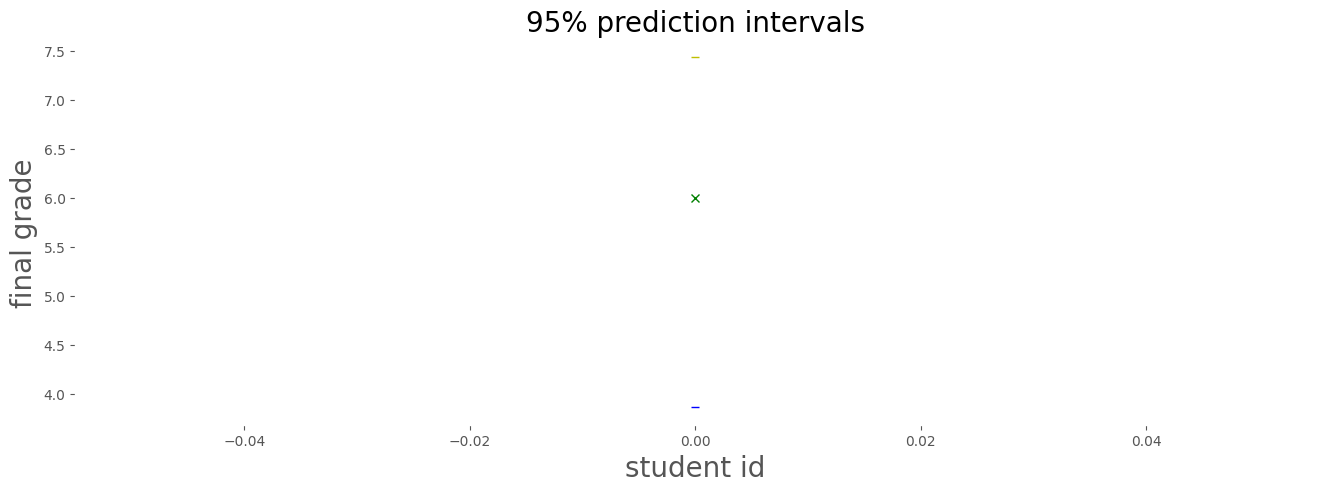

In [35]:
index = res['upper_bound'] < 10
# print(res[res['upper_bound'] < 10])
# print(X_test_g3[index])

max_length = 1
fig = plt.figure(figsize=(16,5))
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(list(y_test_g3.G3[:max_length]), 'gx', label=u'True value')
plt.plot(y_upper_smooth[:max_length], 'y_', label=u'Upper quantile')
plt.plot(y_lower_smooth[:max_length], 'b_', label=u'Lower quantile')
index = np.array(range(0, len(y_upper_smooth[:max_length])))
plt.fill(np.concatenate([index, index[::-1]]),
             np.concatenate([y_upper_smooth[:max_length], y_lower_smooth[:max_length][::-1]]),
             alpha=.2, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('student id',fontsize=20)
plt.ylabel('final grade', fontsize=20)
plt.title('95% prediction intervals', fontsize=20)
#plt.legend(loc='upper left')
plt.show()

### Built in method

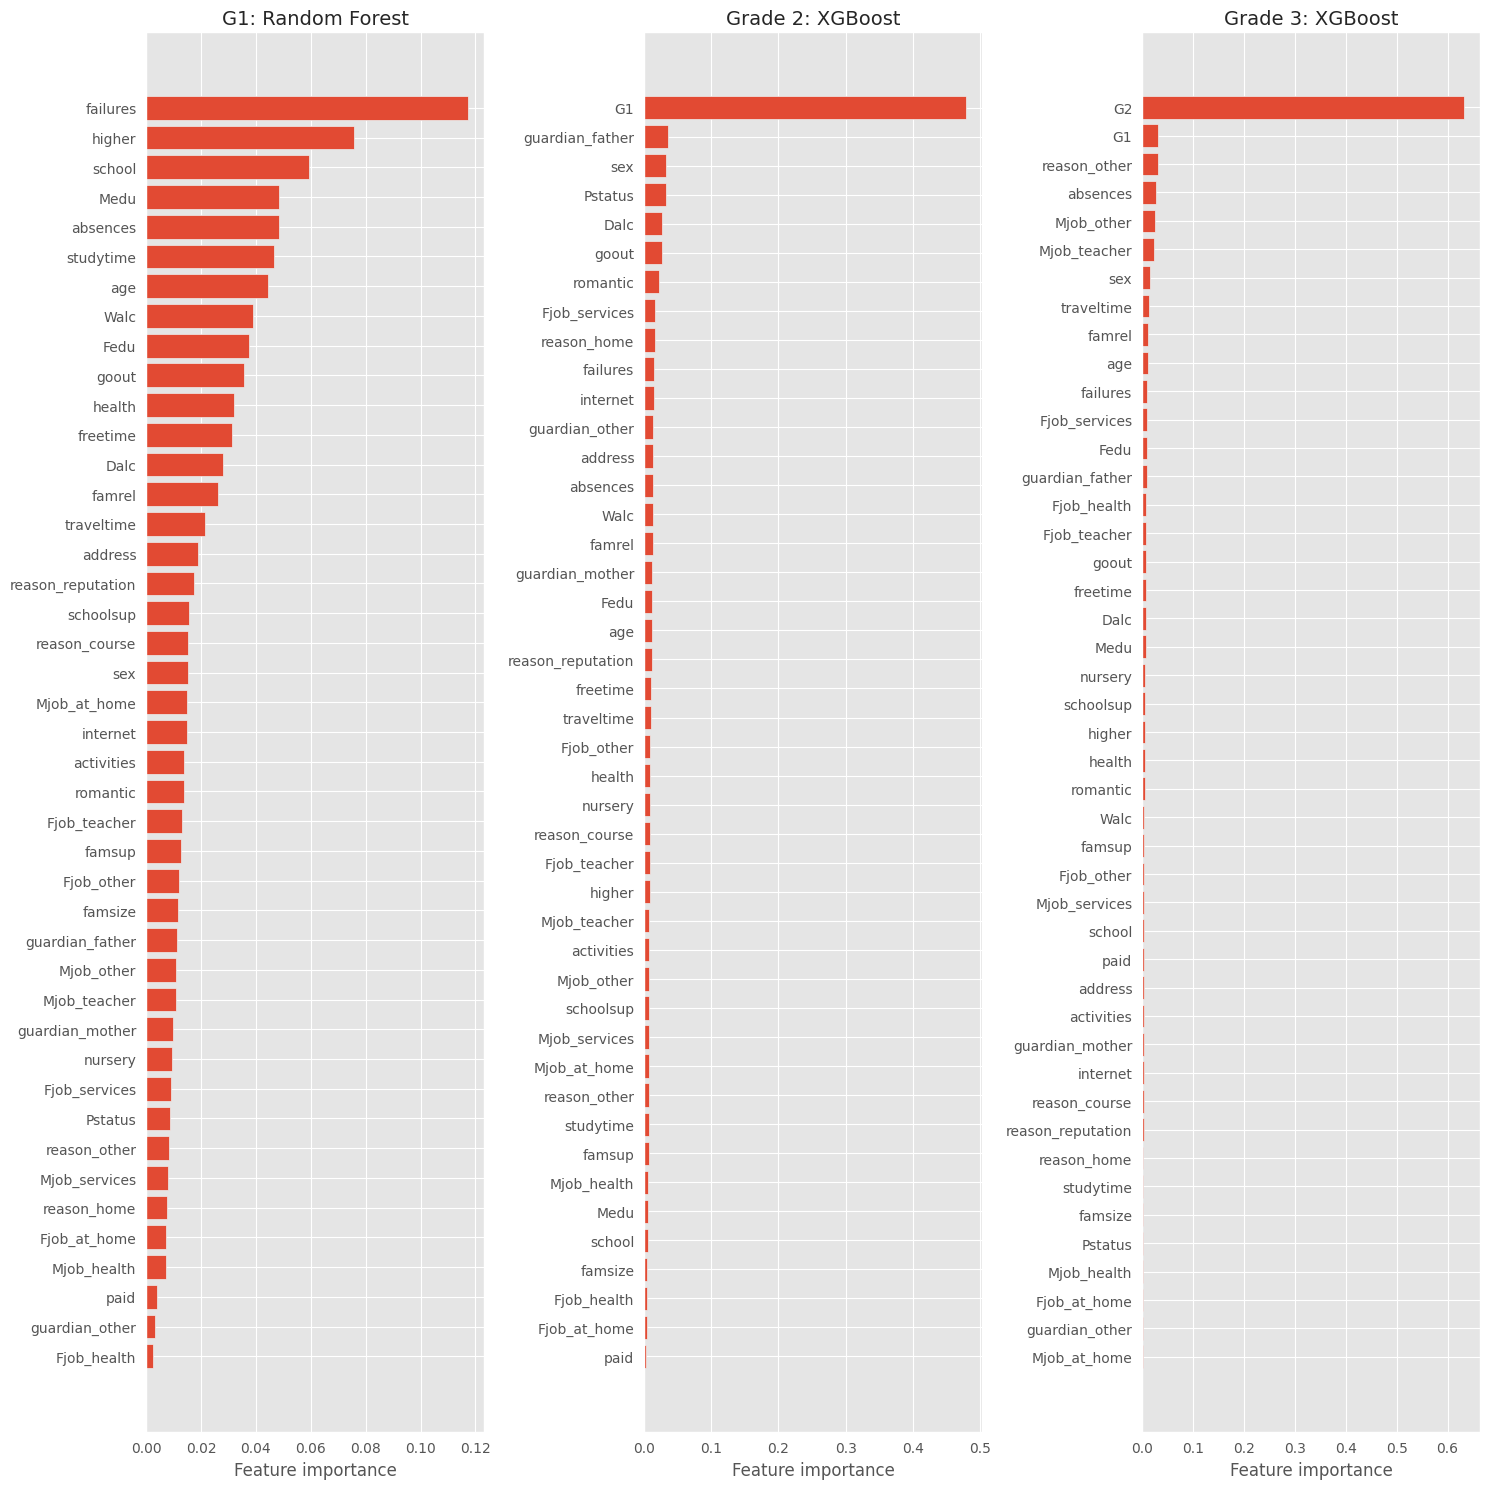

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
#fig.suptitle('Feature importance for multiclass prediction (built-in methods)')
# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) 
ft_weights_g1 = pd.DataFrame(model_g1.feature_importances_, columns=['weight'], index=col_names)
ft_weights_g1.sort_values('weight', inplace=True)

# Plotting feature importances
#plt.figure(figsize=(8,15))
ax1.barh(ft_weights_g1.index, ft_weights_g1.weight, align='center') 
ax1.set_title("G1: Random Forest", fontsize=14)
ax1.set_xlabel("Feature importance")

# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) + ['G1']
ft_weights_g2 = pd.DataFrame(model_g2.feature_importances_, columns=['weight'], index=col_names)
ft_weights_g2.sort_values('weight', inplace=True)

# Plotting feature importances
#plt.figure(figsize=(8,15))
ax2.barh(ft_weights_g2.index, ft_weights_g2.weight, align='center') 
ax2.set_title("Grade 2: XGBoost", fontsize=14)
ax2.set_xlabel("Feature importance")

# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) + ['G1','G2']
ft_weights_g3 = pd.DataFrame(model_g3.feature_importances_, columns=['weight'], index=col_names)
ft_weights_g3.sort_values('weight', inplace=True)

# Plotting feature importances
#plt.figure(figsize=(8,15))
ax3.barh(ft_weights_g3.index, ft_weights_g3.weight, align='center') 
ax3.set_title("Grade 3: XGBoost", fontsize=14)
ax3.set_xlabel("Feature importance")

fig.tight_layout()
plt.show()

### SHAP

In [ ]:
X_enc_mat_g2 = X_enc_mat.merge(y_mat[['G1']], left_index=True, right_index=True)
X_enc_mat_g3 = X_enc_mat.merge(y_mat[['G1','G2']], left_index=True, right_index=True)

In [34]:
# Create object that can calculate shap values
expl_g1 = shap.TreeExplainer(model_g1)
expl_g2 = shap.TreeExplainer(model_g2)
expl_g3 = shap.TreeExplainer(model_g3)
# Calculate Shap values
shap_values_mc_g1 = expl_g1.shap_values(X_enc_mat)
shap_values_mc_g2 = expl_g2.shap_values(X_enc_mat_g2)
shap_values_mc_g3 = expl_g3.shap_values(X_enc_mat_g3)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


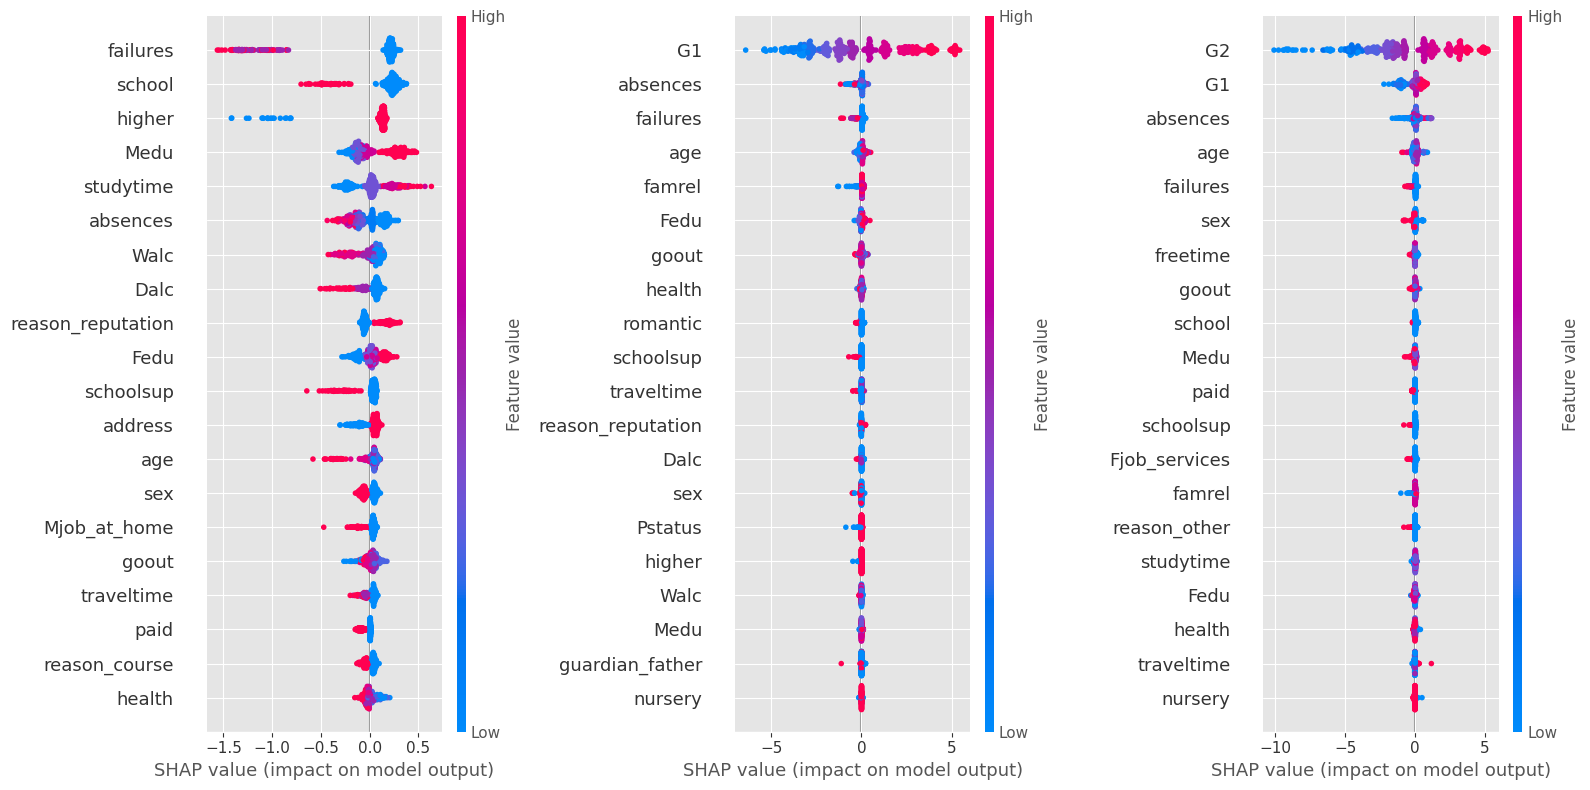

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
shap.summary_plot(shap_values_mc_g1, X_enc_mat, feature_names=X_enc_mat.columns, show=False, plot_size=None)
plt.subplot(1,3,2)
shap.summary_plot(shap_values_mc_g2, X_enc_mat_g2, feature_names=X_enc_mat_g2.columns, show=False, plot_size=None)
plt.subplot(1,3,3)
shap.summary_plot(shap_values_mc_g3, X_enc_mat_g3, feature_names=X_enc_mat_g3.columns, show=False, plot_size=None)
plt.tight_layout()
plt.show()
# on the x axis there is |mean(shap value)|, i.e., average impact on model output magnitude 

In [ ]:
idx_exp=367

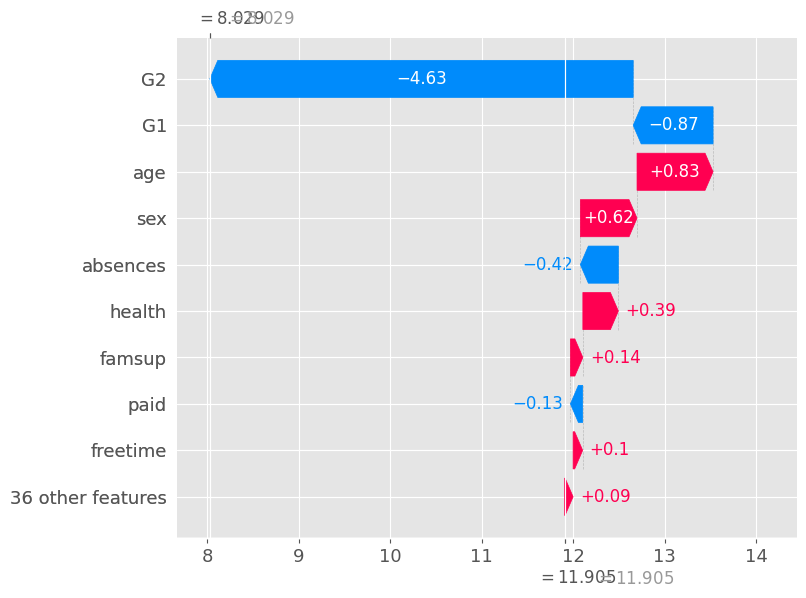

In [ ]:
shap.plots._waterfall.waterfall_legacy(expl_g3.expected_value, shap_values_mc_g3[idx_exp],
                                      feature_names=X_enc_mat_g3.columns.tolist())

In [ ]:
not_important_features_g1 = list(ft_weights_xgb_reg[ft_weights_xgb_reg['weight'] == 0].index)

In [ ]:
errors = predictions - np.array(y_mat['G1'])
sorted_errors = np.argsort(abs(errors))
worse_5 = sorted_errors[-5:]
best_5 = sorted_errors[:5]

print(pd.DataFrame({'worse':errors[worse_5]}))
print()
print(pd.DataFrame({'best':errors[best_5]}))

plt.title('Error distribution')
plt.hist(errors, bins='auto')
plt.show()

In [ ]:
# Scaling
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = pd.DataFrame(sc_X.fit_transform(X_mat_enc), columns=X_mat_enc.columns)
# y = pd.DataFrame(sc_y.fit_transform(y_mat), columns=y_mat.columns)  

X = X_mat_enc
y = y_mat

In [ ]:
chi_scores = chi2(X, y['G1'])
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=True, inplace=True)
chi_not_important_g1 = list(p_values.loc[lambda x : x >= 0.5].keys())

In [ ]:
explainer = shap.TreeExplainer(model_g1)
shap_values = explainer.shap_values(X)

In [ ]:
# decision plot
shap.decision_plot(explainer.expected_value,  shap_values, feature_names = list(X.columns))

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X.columns)

In [ ]:
# X dataframe idx to explain, common on G1, G2, G3 models
idx_exp = 370

In [ ]:
pd.DataFrame(X.iloc[idx_exp]).T


In [ ]:
# idx_exp = worse_5[0] 

print('Y real value: ', y['G1'].iloc[idx_exp])
print('Predicted value:', g1_model_xgb.predict(pd.DataFrame(X.iloc[idx_exp]).T)[0])

shap.force_plot(explainer.expected_value, shap_values[idx_exp], X.iloc[idx_exp], feature_names=X.columns)

**LIME**
- Intercept is the generated linear model's intercept
- Prediction_local is the predicted output from the linear model
- Right is the predicted value from the XGBoost Rergressor (not LIME's linear model)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), feature_names=X.columns, class_names=['G1'], verbose=True, mode='regression')

In [ ]:
exp = explainer.explain_instance(X.iloc[idx_exp], g1_model_xgb.predict, num_features=10)

In [ ]:
exp.show_in_notebook(show_table=True)

## G2

In [ ]:
# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(g2_model_xgb.feature_importances_, columns=['weight'], index=X_por_enc.merge(y_por[['G1']], left_index=True, right_index=True).columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [ ]:
not_important_features_g2 = list(ft_weights_xgb_reg[ft_weights_xgb_reg['weight'] == 0].index)

In [ ]:
model, predictions, test_metrics = get_test_prediction_on_math(g2_model_xgb, 'G2', X_mat_enc, y_mat)

In [ ]:
errors = predictions - np.array(y_mat['G2'])
sorted_errors = np.argsort(abs(errors))
worse_5 = sorted_errors[-5:]
best_5 = sorted_errors[:5]

print(pd.DataFrame({'worse':errors[worse_5]}))
print()
print(pd.DataFrame({'best':errors[best_5]}))

plt.title('Error distribution')
plt.hist(errors, bins='auto')
plt.show()

In [ ]:
X = X.merge(y[['G1']], left_index=True, right_index=True)
y = y_mat

# Scaling
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = pd.DataFrame(sc_X.fit_transform(Xmerge), columns=Xmerge.columns)
# y = pd.DataFrame(sc_y.fit_transform(y_mat), columns=y_mat.columns)  

In [ ]:
chi_scores = chi2(X, y['G2'])
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=True, inplace=True)
chi_not_important_g2 = list(p_values.loc[lambda x : x >= 0.5].keys())

In [ ]:
explainer = shap.TreeExplainer(g2_model_xgb)
shap_values = explainer.shap_values(X)

In [ ]:
# decision plot
shap.decision_plot(explainer.expected_value,  shap_values, feature_names = list(X.columns))

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X.columns)

In [ ]:
# idx_exp = worse_5[0]

print('Y real value: ', y['G2'].iloc[idx_exp])
print('Predicted value:', g2_model_xgb.predict(pd.DataFrame(X.iloc[idx_exp]).T)[0])

shap.force_plot(explainer.expected_value, shap_values[idx_exp], X.iloc[idx_exp], feature_names=X.columns)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), feature_names=X.columns, class_names=['G2'], verbose=True, mode='regression')

In [ ]:
exp = explainer.explain_instance(X.iloc[idx_exp], g2_model_xgb.predict, num_features=10)

In [ ]:
exp.show_in_notebook(show_table=True)

## G3

In [ ]:
# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(g3_model_xgb.feature_importances_, columns=['weight'], index=X_por_enc.merge(y_por[['G1','G2']], left_index=True, right_index=True).columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [ ]:
not_important_features_g3 = list(ft_weights_xgb_reg[ft_weights_xgb_reg['weight'] == 0].index)

In [ ]:
model, predictions, test_metrics = get_test_prediction_on_math(g3_model_xgb, 'G3', X_mat_enc, y_mat)

In [ ]:
errors = predictions - np.array(y_mat['G3'])
sorted_errors = np.argsort(abs(errors))
worse_5 = sorted_errors[-5:]
best_5 = sorted_errors[:5]

print(pd.DataFrame({'worse':errors[worse_5]}))
print()
print(pd.DataFrame({'best':errors[best_5]}))

plt.title('Error distribution')
plt.hist(errors, bins='auto')
plt.show()

In [ ]:
X = X.merge(y[['G2']], left_index=True, right_index=True)
y = y_mat

# Scaling
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = pd.DataFrame(sc_X.fit_transform(Xmerge), columns=Xmerge.columns)
# y = pd.DataFrame(sc_y.fit_transform(y_mat), columns=y_mat.columns)  

In [ ]:
chi_scores = chi2(X, y['G2'])
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=True, inplace=True)
chi_not_important_g3 = list(p_values.loc[lambda x : x >= 0.5].keys())

In [ ]:
explainer = shap.TreeExplainer(g3_model_xgb)
shap_values = explainer.shap_values(X)

In [ ]:
# decision plot
shap.decision_plot(explainer.expected_value,  shap_values, feature_names = list(X.columns))

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X.columns)

In [ ]:
# idx_exp = worse_5[0]

print('Y real value: ', y['G3'].iloc[idx_exp])
print('Predicted value:', g3_model_xgb.predict(pd.DataFrame(X.iloc[idx_exp]).T)[0])

shap.force_plot(explainer.expected_value, shap_values[idx_exp], X.iloc[idx_exp], feature_names=X.columns)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), feature_names=X.columns, class_names=['G3'], verbose=True, mode='regression')

In [ ]:
exp = explainer.explain_instance(X.iloc[idx_exp], g3_model_xgb.predict, num_features=10)

In [ ]:
exp.show_in_notebook(show_table=True)

## Model re-train on less features

Not important common features between the 3 models **in terms of feature importance returned by the model itself**

In [ ]:
set(not_important_features_g1) & set(not_important_features_g2) & set(not_important_features_g3)

Not important common features between the 3 models **in terms of chi feature selection**

In [ ]:
set(chi_not_important_g1) & set(chi_not_important_g2) & set(chi_not_important_g3)

retrain dell'xgboost sul portoguese, togliendo:
- prima le non important dalla feature importnate
- non important dalla chi selection

confrontarne i risultati sia con il test del portoghese, sia con il test di matematica generale